In [1]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking, GRU
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from numpy import load
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


np.random.seed(1337)# setting the random seed value

In [2]:
path_dataset = "ILDC_multi.csv" # path to dataset

In [3]:
dataset = pd.read_csv(path_dataset) # loading dataset

In [4]:
# path to transformer generated chunk embeddings eg. XLNet etc.
path_transformer_chunk_embeddings_train = 'XLNet_full/XLNet_train.npy' 
path_transformer_chunk_embeddings_dev = 'XLNet_full/XLNet_dev.npy'
path_transformer_chunk_embeddings_test = 'XLNet_full/XLNet_test.npy'

In [5]:
# loading the chunk embeddings
x_train0 = load(path_transformer_chunk_embeddings_train, allow_pickle = True)
x_dev0 = load(path_transformer_chunk_embeddings_dev, allow_pickle= True)
x_test0 = load(path_transformer_chunk_embeddings_test, allow_pickle= True)

In [6]:
# loading the corresponding label for each case in dataset
dev = dataset.loc[dataset['split'] == 'dev'] 
train = dataset.loc[dataset['split'] == 'train'] 
test = dataset.loc[dataset['split'] == 'test'] 

y_train0 = []
for i in range(train.shape[0]):
    y_train0.append(train.loc[i,'label'])  
    
y_dev0 = []
for i in range(dev.shape[0]):
    y_dev0.append(dev.loc[i+32305,'label'])

y_test0 = []
for i in range(test.shape[0]):
    y_test0.append(test.loc[i+33299,'label'])

In [7]:
# Combine the chunk embeddings and labels for each case
x_train = []
for i in range(len(x_train0)):
    x_train.append([x_train0[i],y_train0[i]])

before_train_len = len(x_train)

x_dev = []
for i in range(len(x_dev0)):
    x_dev.append([x_dev0[i],y_dev0[i]])

# Now combine the train and dev data to form a new train data
x_train = x_train + x_dev

np.random.shuffle(x_train)

# store value of index for splitting the data
index = int(before_train_len)

x_train0 = []
y_train0 = []
for i in range(0, index):
    x_train0.append(x_train[i][0])
    y_train0.append(x_train[i][1])

x_dev0 = []
y_dev0 = []
for i in range(index, len(x_train)):
    x_dev0.append(x_train[i][0])
    y_dev0.append(x_train[i][1])

In [8]:
from keras import layers
from keras.models import Model

# Input layer to convert into required tensor shape
text_input = layers.Input(shape=(None,768,), dtype='float32', name='text')

# Masking layer to mask the padded values
l_mask = layers.Masking(mask_value=-99.)(text_input)

# After masking we encode the vector using 2 bidirectional GRU's
encoded_text1 = layers.Bidirectional(layers.GRU(100,return_sequences=True))(l_mask)

# Add an average pooling layer
encoded_text2 = layers.MaxPooling1D(pool_size=2)(encoded_text1)

encoded_text3 = layers.Bidirectional(layers.GRU(100,return_sequences=True))(encoded_text2)

# Add an average pooling layer
encoded_text4 = layers.MaxPooling1D(pool_size=2)(encoded_text3)

# Add a dropout layer after encoding
dropout_layer = layers.Dropout(0.2)(encoded_text4)

# Add a dense layer after encoding
out_dense = layers.Dense(30, activation='relu')(dropout_layer)

# And we add a sigmoid classifier on top
out = layers.Dense(1, activation='sigmoid')(out_dense)

# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 768)]       0         
                                                                 
 masking (Masking)           (None, None, 768)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        522000    
 l)                                                              
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 200)        0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 200)        181200    
 nal)                                                            
                                                             

In [9]:
for layer in model.layers:
    print(layer.name)
    print(layer.input_shape)
    print(layer.output_shape)
    print()

text
[(None, None, 768)]
[(None, None, 768)]

masking
(None, None, 768)
(None, None, 768)

bidirectional
(None, None, 768)
(None, None, 200)

max_pooling1d
(None, None, 200)
(None, None, 200)

bidirectional_1
(None, None, 200)
(None, None, 200)

max_pooling1d_1
(None, None, 200)
(None, None, 200)

dropout
(None, None, 200)
(None, None, 200)

dense
(None, None, 200)
(None, None, 30)

dense_1
(None, None, 30)
(None, None, 1)



In [10]:
num_sequences = len(x_train0)
batch_size = 32 
batches_per_epoch =  int(num_sequences/batch_size)
num_features= 768
def train_generator(): # function to generate batches of corresponding batch size
    x_list= x_train0
    y_list =  y_train0
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(x_train0[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            # padding the vectors with respect to the maximum sequence of each batch and not the whole training data
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [11]:
num_sequences_val = len(x_dev0)
batch_size_val = 32
batches_per_epoch_val = int(num_sequences_val/batch_size_val)
num_features= 768
def val_generator():# Similar function to generate validation batches
    x_list= x_dev0
    y_list =  y_dev0
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(x_dev0[:(b + 1) * batch_size_val][-batch_size_val:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), 0)
            y_train = np.zeros((batch_size_val,  1))
            # padding the vectors with respect to the maximum sequence of each batch and not the whole validation data
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [12]:
# Setting the callback and training the model
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=2, verbose=2,mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

history= model.fit(train_generator(), steps_per_epoch=batches_per_epoch, epochs=20,validation_data=val_generator(), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/20
1009/1009 [==============================] - 95s 79ms/step - loss: 0.4628 - acc: 0.7808 - val_loss: 0.4806 - val_acc: 0.7780 - lr: 0.0010
Epoch 2/20
1009/1009 [==============================] - 76s 75ms/step - loss: 0.4379 - acc: 0.7948 - val_loss: 0.4761 - val_acc: 0.7739 - lr: 0.0010
Epoch 3/20
1009/1009 [==============================] - ETA: 0s - loss: 0.4255 - acc: 0.8021
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
1009/1009 [==============================] - 75s 74ms/step - loss: 0.4255 - acc: 0.8021 - val_loss: 0.4792 - val_acc: 0.7734 - lr: 0.0010
Epoch 4/20
1009/1009 [==============================] - 77s 76ms/step - loss: 0.4115 - acc: 0.8094 - val_loss: 0.4878 - val_acc: 0.7549 - lr: 9.5000e-04
Epoch 5/20
1009/1009 [==============================] - ETA: 0s - loss: 0.3954 - acc: 0.8186
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009025000152178108.
1009/1009 [==============================] - 80s 80ms/step - loss: 0.3954

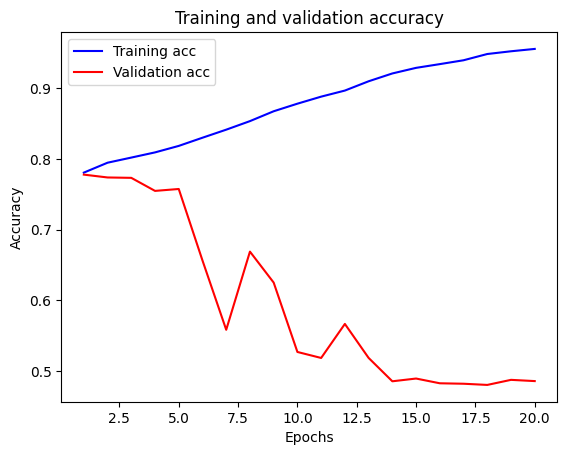

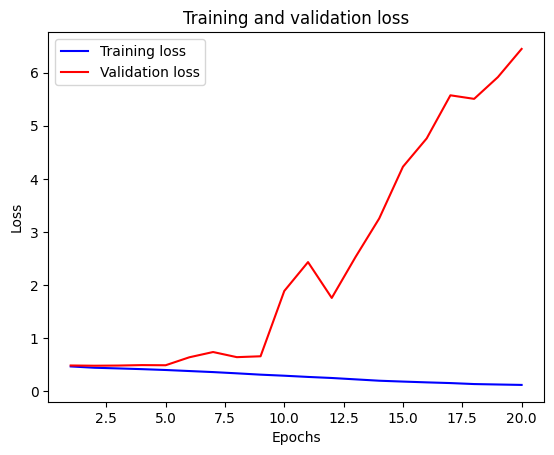

In [13]:
# Plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b-', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
# Extract training history
train_loss = history.history['loss']
train_acc = history.history['acc']

# Extract validation history
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

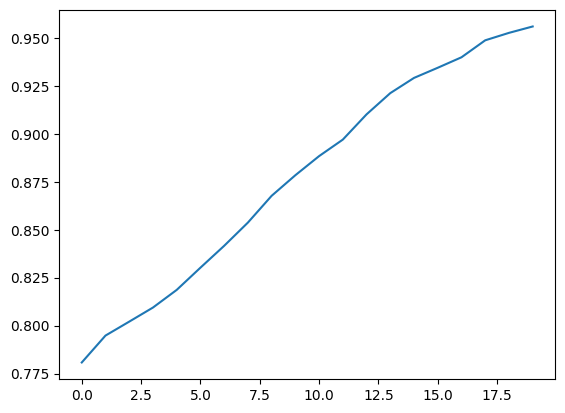

In [15]:
import matplotlib.pyplot as plt

# plt.plot(train_loss)
plt.plot(train_acc)

In [16]:
num_sequences_test = len(x_test0)
batch_size_test = 32
batches_per_epoch_test = int(num_sequences_test/batch_size_test) + 1
num_features= 768

def test_generator(): # function to generate batches of corresponding batch size
    x_list= x_test0
    y_list =  y_test0
    # Generate batches
    while True:
        for b in range(batches_per_epoch_test):
            if(b == batches_per_epoch_test-1): # An extra if else statement just to manage the last batch as it's size might not be equal to batch size 
              longest_index = num_sequences_test - 1

              timesteps = len(max(x_test0[:longest_index + 1][-batch_size_test:], key=len))
              x_train = np.full((longest_index - b*batch_size_test, timesteps, num_features), -99.)
              y_train = np.zeros((longest_index - b*batch_size_test,  1))
              for i in range(longest_index - b*batch_size_test):
                  li = b * batch_size_test + i
                  x_train[i, 0:len(x_list[li]), :] = x_list[li]
                  y_train[i] = y_list[li]
            else:
                longest_index = (b + 1) * batch_size_test - 1
                timesteps = len(max(x_test0[:(b + 1) * batch_size_test][-batch_size_test:], key=len))
                x_train = np.full((batch_size_test, timesteps, num_features), -99.)
                y_train = np.zeros((batch_size_test,  1))
                # padding the vectors with respect to the maximum sequence of each batch and not the whole test data
                for i in range(batch_size_test):
                    li = b * batch_size_test + i
                    x_train[i, 0:len(x_list[li]), :] = x_list[li]
                    y_train[i] = y_list[li]
            yield x_train, y_train

In [17]:
# evaluating on the test data
test_loss, test_acc=  model.evaluate_generator(test_generator(), steps= batches_per_epoch_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


C:\Users\Rahul Varma\AppData\Local\Temp\ipykernel_10752\4112675470.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc=  model.evaluate_generator(test_generator(), steps= batches_per_epoch_test)


Test Loss: 1.4827882051467896
Test Accuracy: 0.7456684112548828


In [18]:
# defining a function which calculates various metrics such as micro and macro precision, accuracy and f1
def metrics_calculator(preds, test_labels):
    cm = confusion_matrix(test_labels, preds)
    TP = []
    FP = []
    FN = []
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[i][j]

        FN.append(summ)
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[j][i]

        FP.append(summ)
    for i in range(0,2):
        TP.append(cm[i][i])
    precision = []
    recall = []
    for i in range(0,2):
        precision.append(TP[i]/(TP[i] + FP[i]))
        recall.append(TP[i]/(TP[i] + FN[i]))

    macro_precision = sum(precision)/2
    macro_recall = sum(recall)/2
    micro_precision = sum(TP)/(sum(TP) + sum(FP))
    micro_recall = sum(TP)/(sum(TP) + sum(FN))
    micro_f1 = (2*micro_precision*micro_recall)/(micro_precision + micro_recall)
    macro_f1 = (2*macro_precision*macro_recall)/(macro_precision + macro_recall)
    print("macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1")
    return macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1

In [19]:
preds = model.predict_generator(test_generator(), steps=batches_per_epoch_test)
y_pred = (preds > 0.5).numpy()
for i in range(y_pred.shape[0]):
    count_zeros = np.sum(y_pred[i] == 0)
    count_ones = np.sum(y_pred[i] == 1)
    if count_zeros > count_ones:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

# Calculating all metrics on test data predicted label
print(metrics_calculator(tuple(y_pred), y_test0[:-1]))

C:\Users\Rahul Varma\AppData\Local\Temp\ipykernel_10752\1136303387.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator(), steps=batches_per_epoch_test)


macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1
(0.7549594430606119, 0.7431734124670397, 0.7490200665493847, 0.7427440633245382, 0.7427440633245382, 0.7427440633245382)


In [20]:
# getting the predicted labels on the dev data
preds = model.predict_generator(val_generator(), steps= batches_per_epoch_val)
y_pred_dev = (preds > 0.5).numpy()
for i in range(y_pred_dev.shape[0]):
    count_zeros = np.sum(y_pred_dev[i] == 0)
    count_ones = np.sum(y_pred_dev[i] == 1)
    if count_zeros > count_ones:
        y_pred_dev[i] = 0
    else:
        y_pred_dev[i] = 1

# Calculating all metrics on dev data predicted label
print(metrics_calculator(tuple(y_pred_dev), y_dev0[:-2]))

C:\Users\Rahul Varma\AppData\Local\Temp\ipykernel_10752\415520231.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(val_generator(), steps= batches_per_epoch_val)


macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1
(0.6085052402669968, 0.5448899773831986, 0.5749432658168011, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355)


In [21]:
# saving the trained model
model.save('BIGRU_XLNet.h5')  # creates a HDF5 file 'BIGRU_XLNet.h5'

In [22]:
# loading the model
# model = load_model('BIGRU_XLNet.h5')